# Quick Start with Dynap-SE2

This notebook gives you a quick overview of taking a network from a high-level Python simulator through to deployment on Dynap-SE2 chip without going into too much detail.
Particularly this notebook shows how to:

1. Build a Dynap-SE2 compatible **network with Rockpool**, using `DynapSim` and `LinearJax` layers.
2. Extract the **computational graph** for that network containing all parameters needed to specify the chip configuration.
3. **Map** the computational graph to Dynap-SE2 hardware, allocating hardware resources wisely.
4. **Quantize** the network parameters to make sure that they fit.
5. **Connect and Configure** the chip, deploy the network.
6. **Simulate on Dynap-SE2** and read the results.
7. **Simulate on CPU** and see how the network affected by all those transformations and quantizations affected the network behaviour.

## Imports

In [1]:
# - Switch off warnings
import warnings

warnings.filterwarnings("ignore")

import numpy as np

# - Rockpool imports
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential
from rockpool.timeseries import TSEvent, TSContinuous

# - Dynap-SE imports
from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    DynapseSamna,
    dynapsim_net_from_config,
)

# - Tutorial Utils
from utils import poisson_spike_train, plot_Ix, visualize_device_sim

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [4.8, 2.4]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 10


## Tutorial Utils

In [2]:
%psource poisson_spike_train

def poisson_spike_train(
    n_channels: int,
    duration: float,
    rate: float,
    dt: float,
    batch_size: int = 1,
    seed: Optional[int] = None,
) -> np.ndarray:
    """
    random_spike_train generates a Poisson frozen random spike train

    :param n_channels: number of channels
    :type n_channels: float
    :param duration: simulation duration in seconds
    :type duration: float
    :param rate: expected mean spiking rate in Hertz(1/s)
    :type rate: float
    :param dt: time step length
    :type dt: float, optional
    :param batch_size: number of batches in data, defaults to 1
    :type batch_size: int, optional
    :param seed: the random number seed
    :type seed: int, optional
    :raises ValueError: no spike generated due to low firing rate or very short simulation time
    :return: randomly generated discrete spike train
    :rtype: np.ndarray
    """
    np.random.seed(seed)
    steps = int(np.round(duration / dt))
    raster = np.random.poisson(rate * dt, (

In [3]:
%psource plot_Ix

def plot_Ix(
    Ix_record: np.ndarray,
    Ithr: Optional[Union[float, np.ndarray]] = None,
    dt: float = 1e-3,
    name: Optional[str] = None,
    idx_map: Optional[Dict[int, NeuronKey]] = None,
    margin: Optional[float] = 0.2,
    ax: Optional[matplotlib.axes.Axes] = None,
    line_ratio: float = 0.3,
    ylabel: str = "Current (A)",
    *args,
    **kwargs,
) -> TSContinuous:
    """
    plot_Ix converts an `Ix_record` current measurements/recordings obtained from the record dictionary to a `TSContinuous` object and plot

    :param Ix_record: Membrane or synapse currents of the neurons recorded with respect to time (T,N)
    :type Ix_record: np.ndarray
    :param Ithr: Spike threshold or any other upper threshold for neurons. Both a single float number for global spike threshold and an array of numbers for neuron-specific thresholds can be provided. Plotted with dashed lines if provided, defaults to None
    :type Ithr: Optional[float], optional
    :param dt: The discrete tim

In [4]:
%psource visualize_device_sim_results

Object `visualize_device_sim_results` not found.


In [5]:
def plot_vmem(rec: dict, __name: str) -> None:
    plot_Ix(
        rec[__name]["vmem"][0], name=f"{__name} Membrane Potentials", ylabel="Voltage (Volts)"
    )


def plot_isyn(rec: dict, __name: str, *args, **kwargs) -> None:
    plot_Ix(rec[__name]["isyn"][0], name=f"{__name} Synapse Currents")


def plot_raster(rec: dict, __name: str, dt: float) -> None:
    TSEvent.from_raster(
        rec[__name]["spikes"][0], name=f"{__name} Spiking Output", dt=dt
    ).plot()
    plt.tight_layout()


## Step 1 : Build a network in Rockpool

In this example, we will directly use the `DynapSim` layers in model definition. It's highly recommended to use this, if the aim is to deploy to the chip; however, it's also possible to convert an LIF network to Dynap-SE2 configuration. Conversion is covered in a seperate tutorial.

### Step 1.1 : Define the size of the network layers

In [6]:
Nin = 8
Nhidden1 = 4
Nhidden2 = 2
dt = 1e-3


### Step 1.2 : Define the network architecture
Please keep in mind that between `DynapSim` layers we should have `LinearJax` layers. `DynapSim` layers are only allowed to store square recurrent weight matrices and to transfer the spikes to forward layers, we need `LinearJax`.

In [7]:
net = Sequential(
    LinearJax((Nin, Nhidden1), has_bias=False),
    DynapSim((Nhidden1, Nhidden1), has_rec=True, dt=dt),
    LinearJax((Nhidden1, Nhidden2), has_bias=False),
    DynapSim((Nhidden2, Nhidden2), has_rec=True, dt=dt),
)
net


JaxSequential  with shape (8, 2) {
    LinearJax '0_LinearJax' with shape (8, 4)
    DynapSim '1_DynapSim' with shape (4, 4)
    LinearJax '2_LinearJax' with shape (4, 2)
    DynapSim '3_DynapSim' with shape (2, 2)
}

## Step 2 : Simulate
Now we have the network, and with a random poisson spike train, we can observe the network activty.

### Step 2.1 : Generate Input Spike Train

Generate a random poisson spike train of 500 ms with a mean firing rate of 20 Hz.

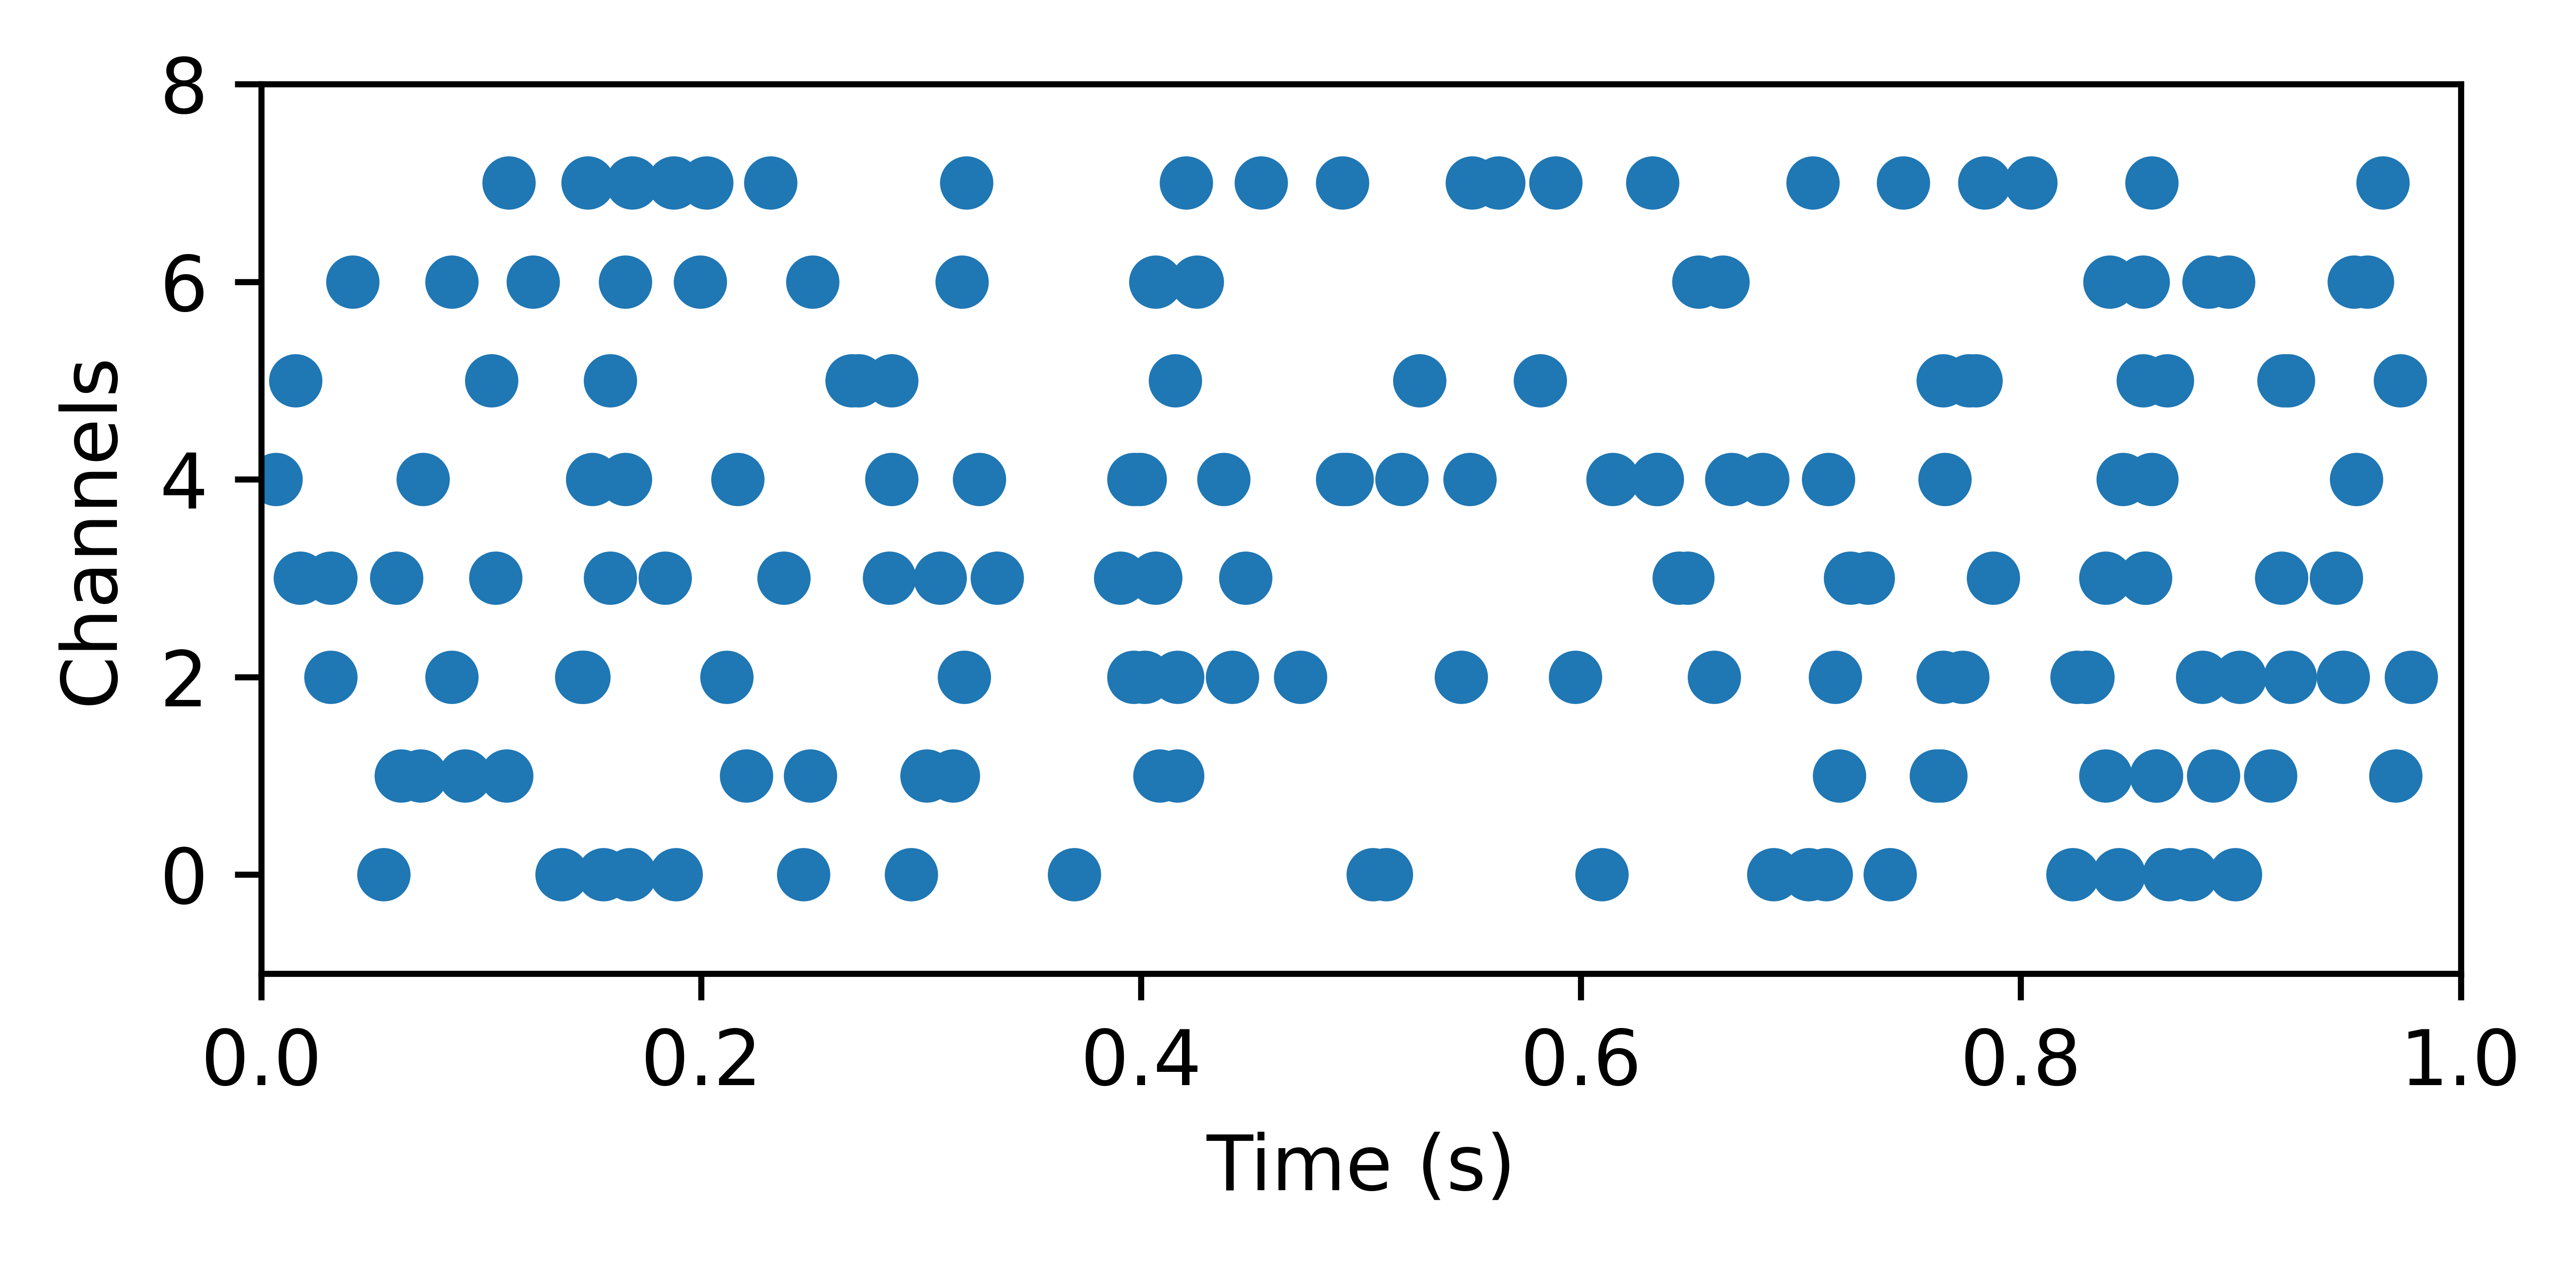

In [8]:
input_spikes = poisson_spike_train(n_channels=Nin, duration=1.0, rate=20, dt=dt)
TSEvent.from_raster(input_spikes[0], dt=dt).plot()
plt.tight_layout()


### Step 2.2 : Run
Now let's run the model and record the state changes over time. Note that input spike train generator function append a batch dimension. Therefore, we get the first item from input spikes.

In [9]:
net.reset_state()
out, state, rec = net(input_spikes[0])


### Step 2.3 : First DynapSim Layer

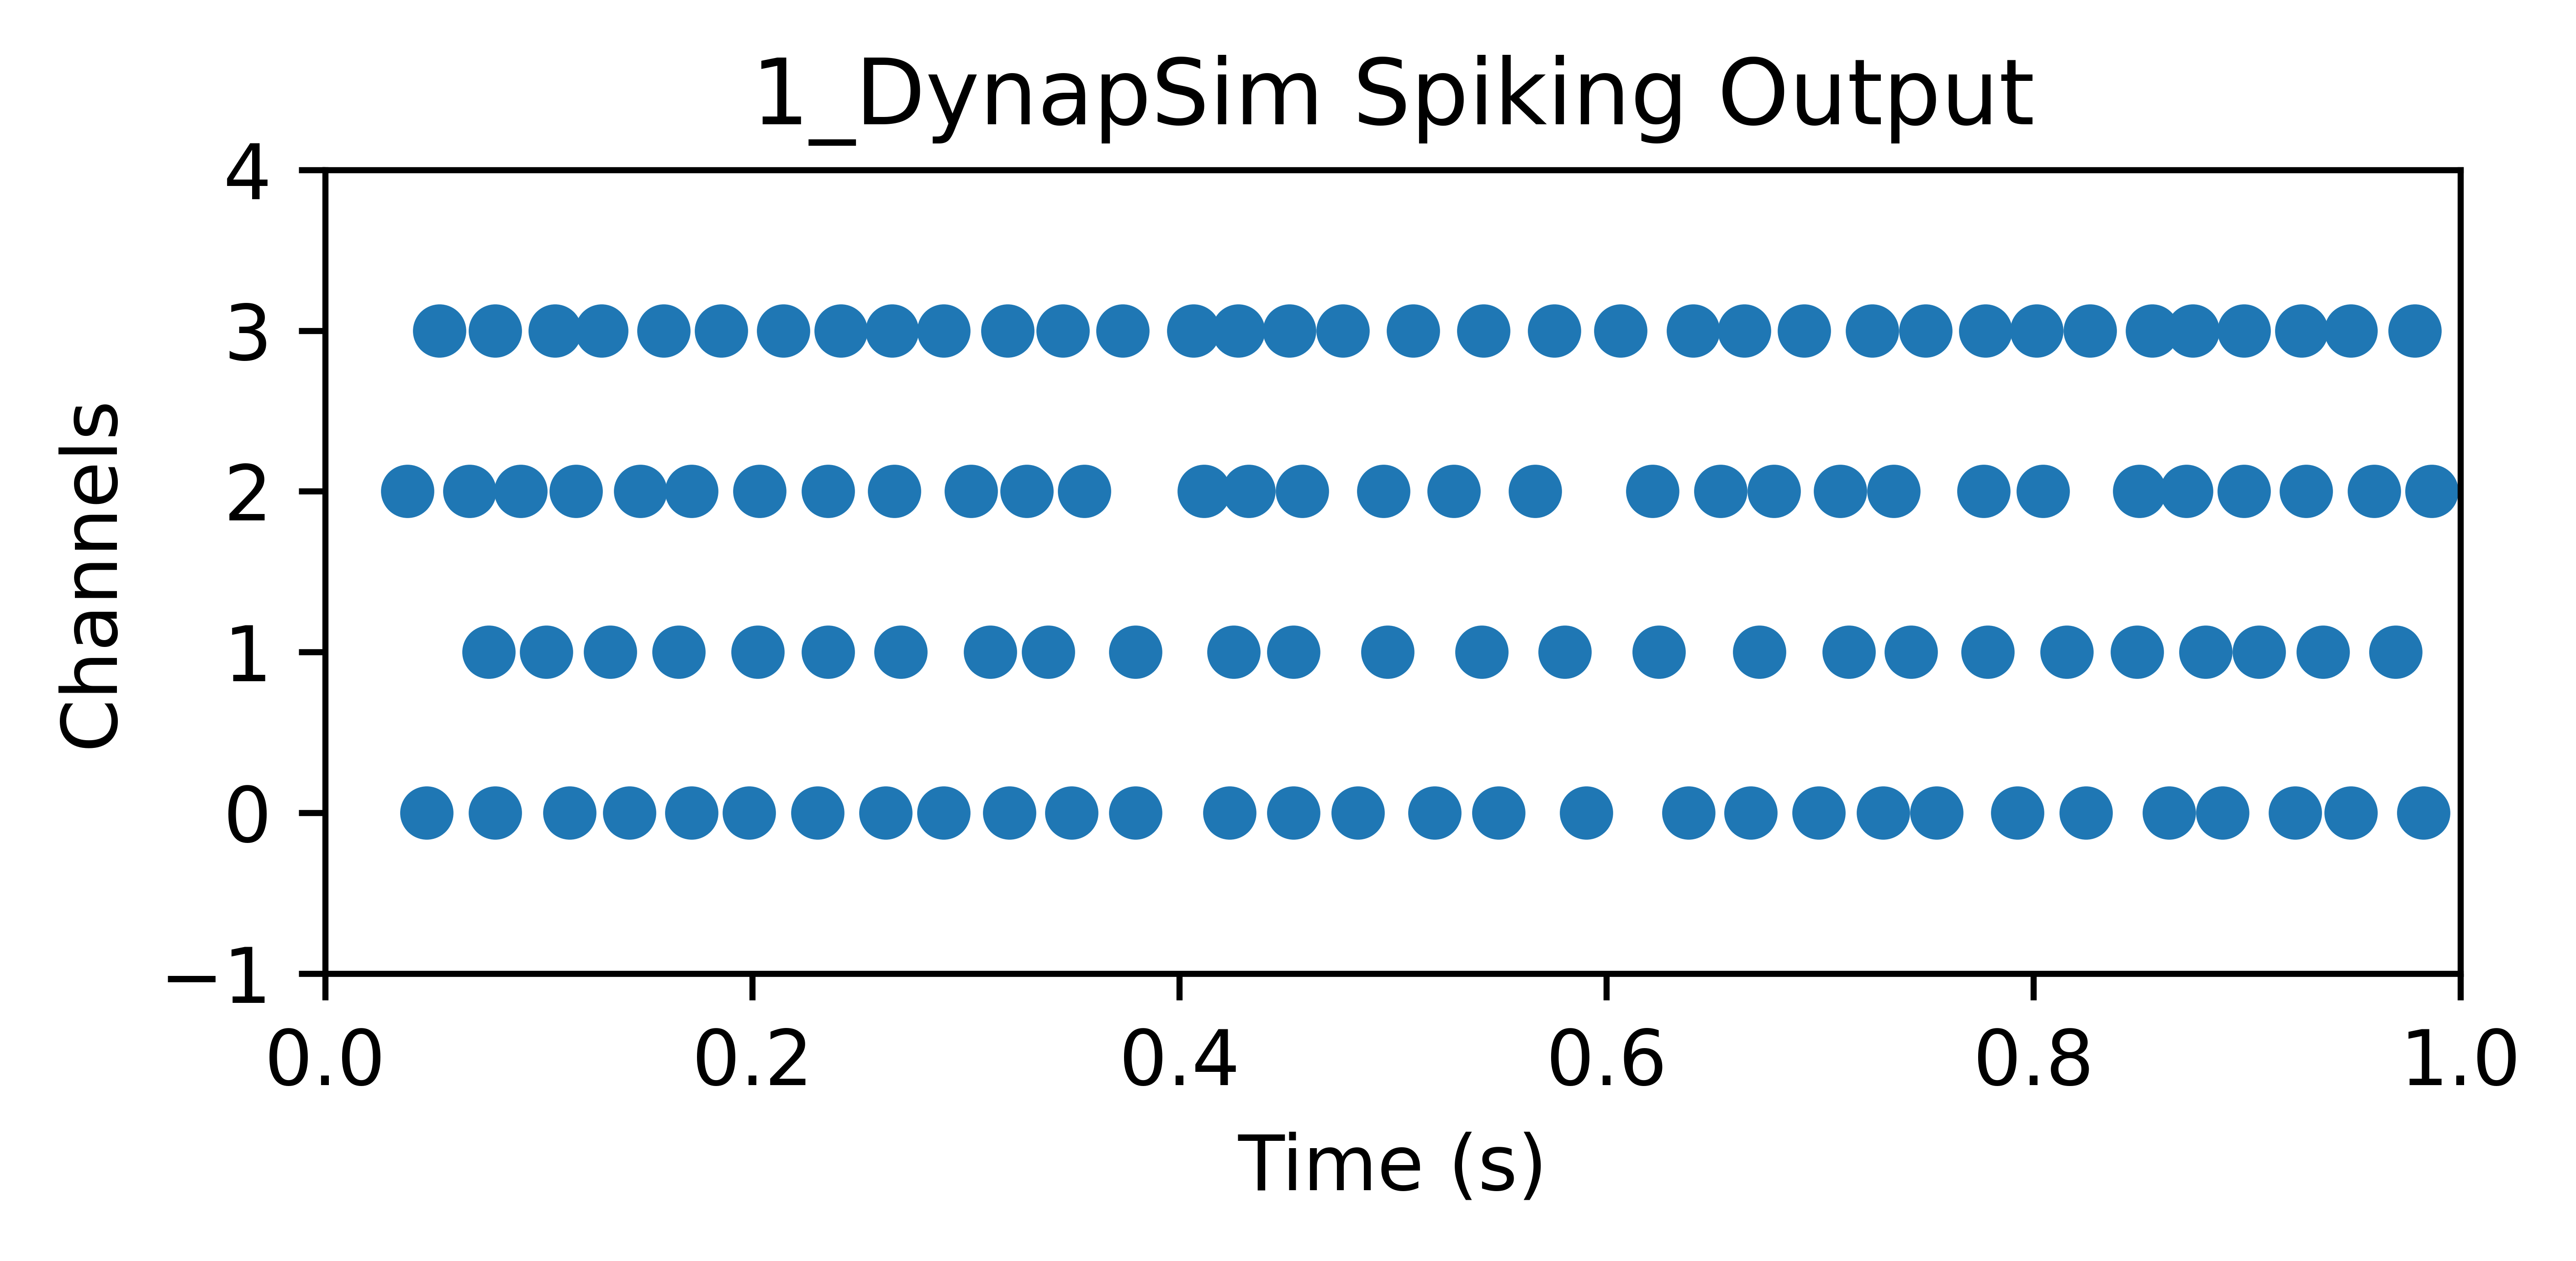

In [10]:
plot_raster(rec, "1_DynapSim", dt)

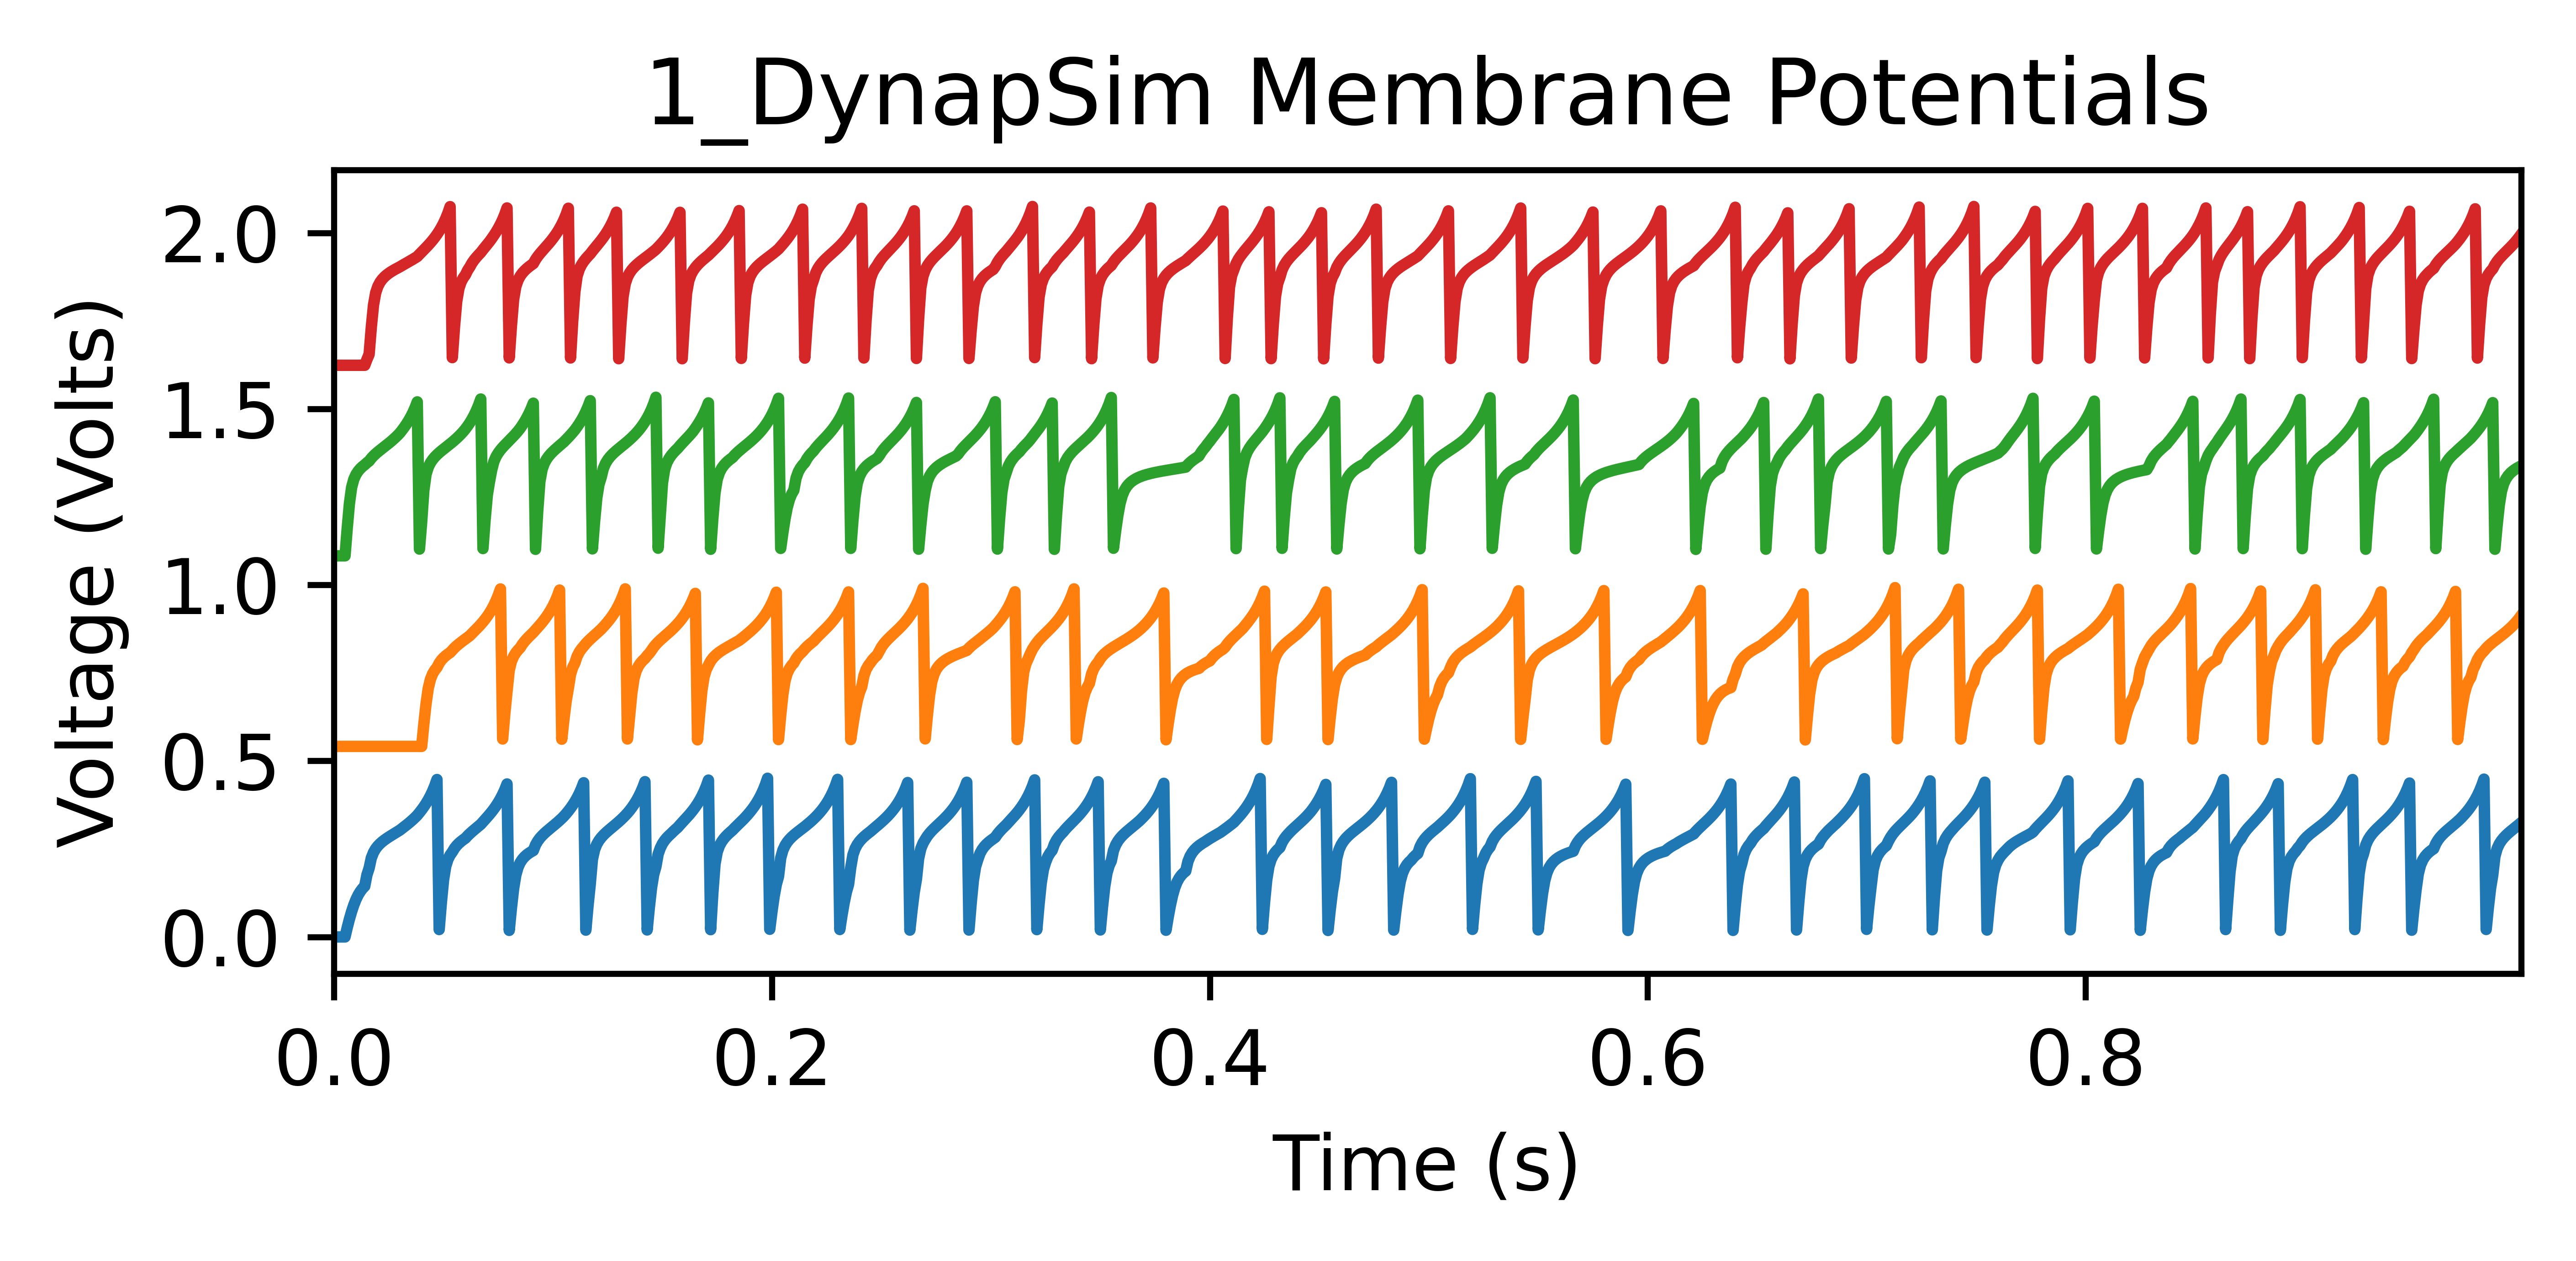

In [11]:
plot_vmem(rec, "1_DynapSim")


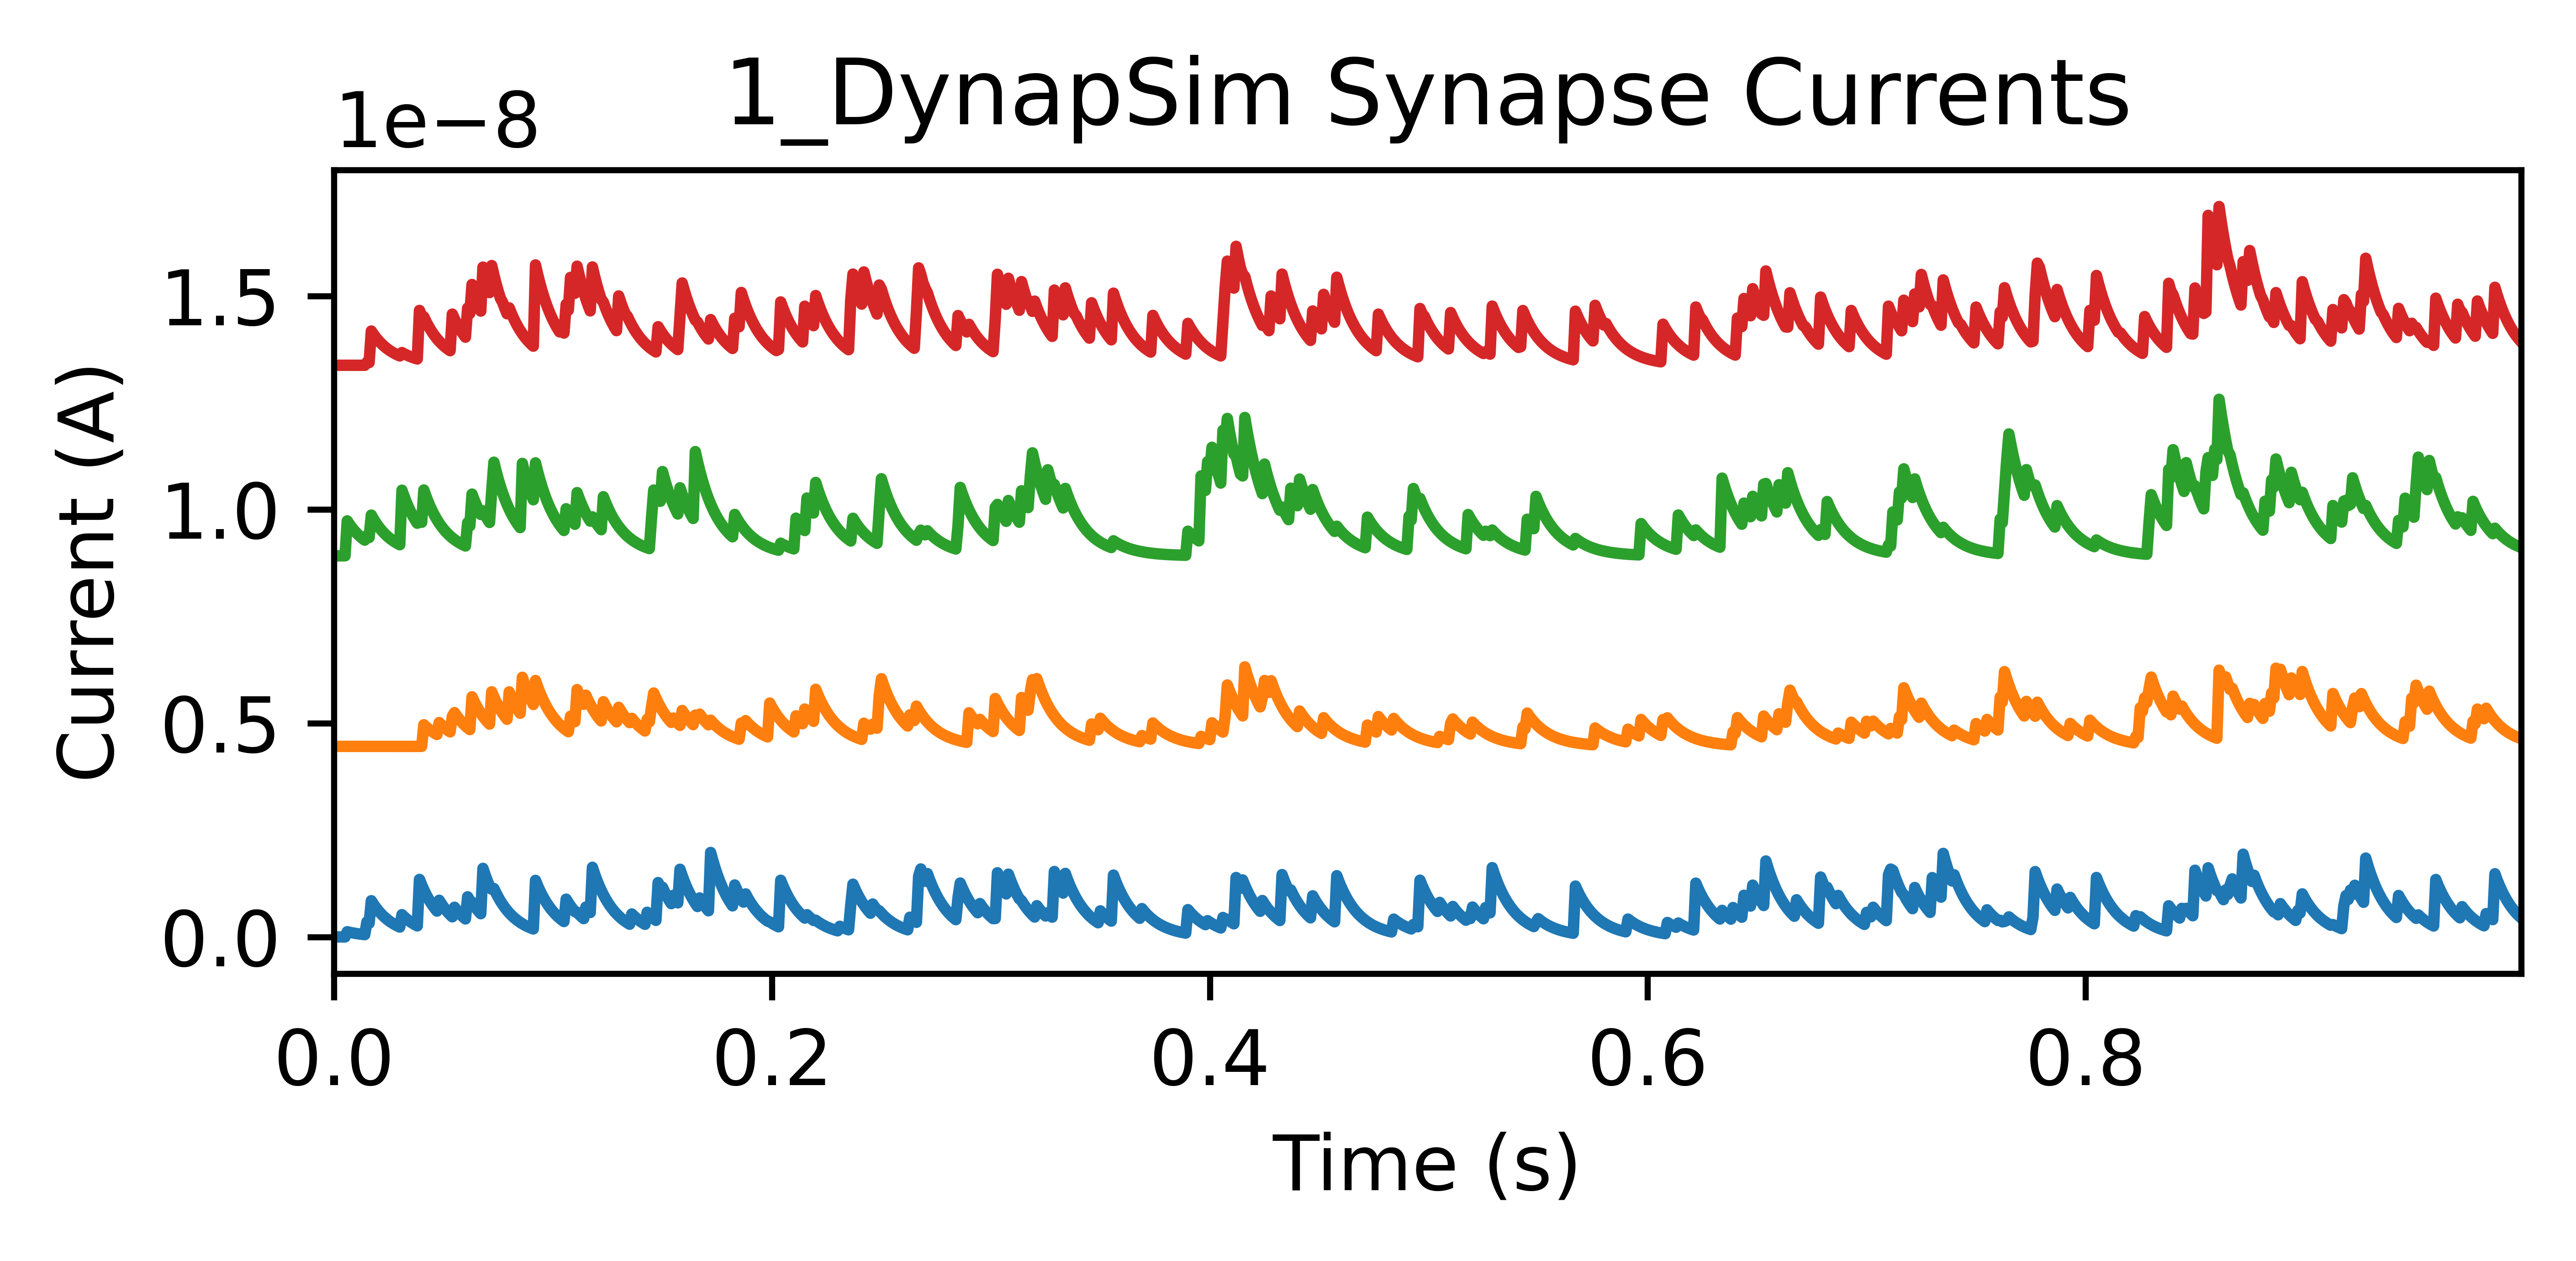

In [12]:
plot_isyn(rec, "1_DynapSim")


### Step 2.4 : Second DynapSim Layer (Output)

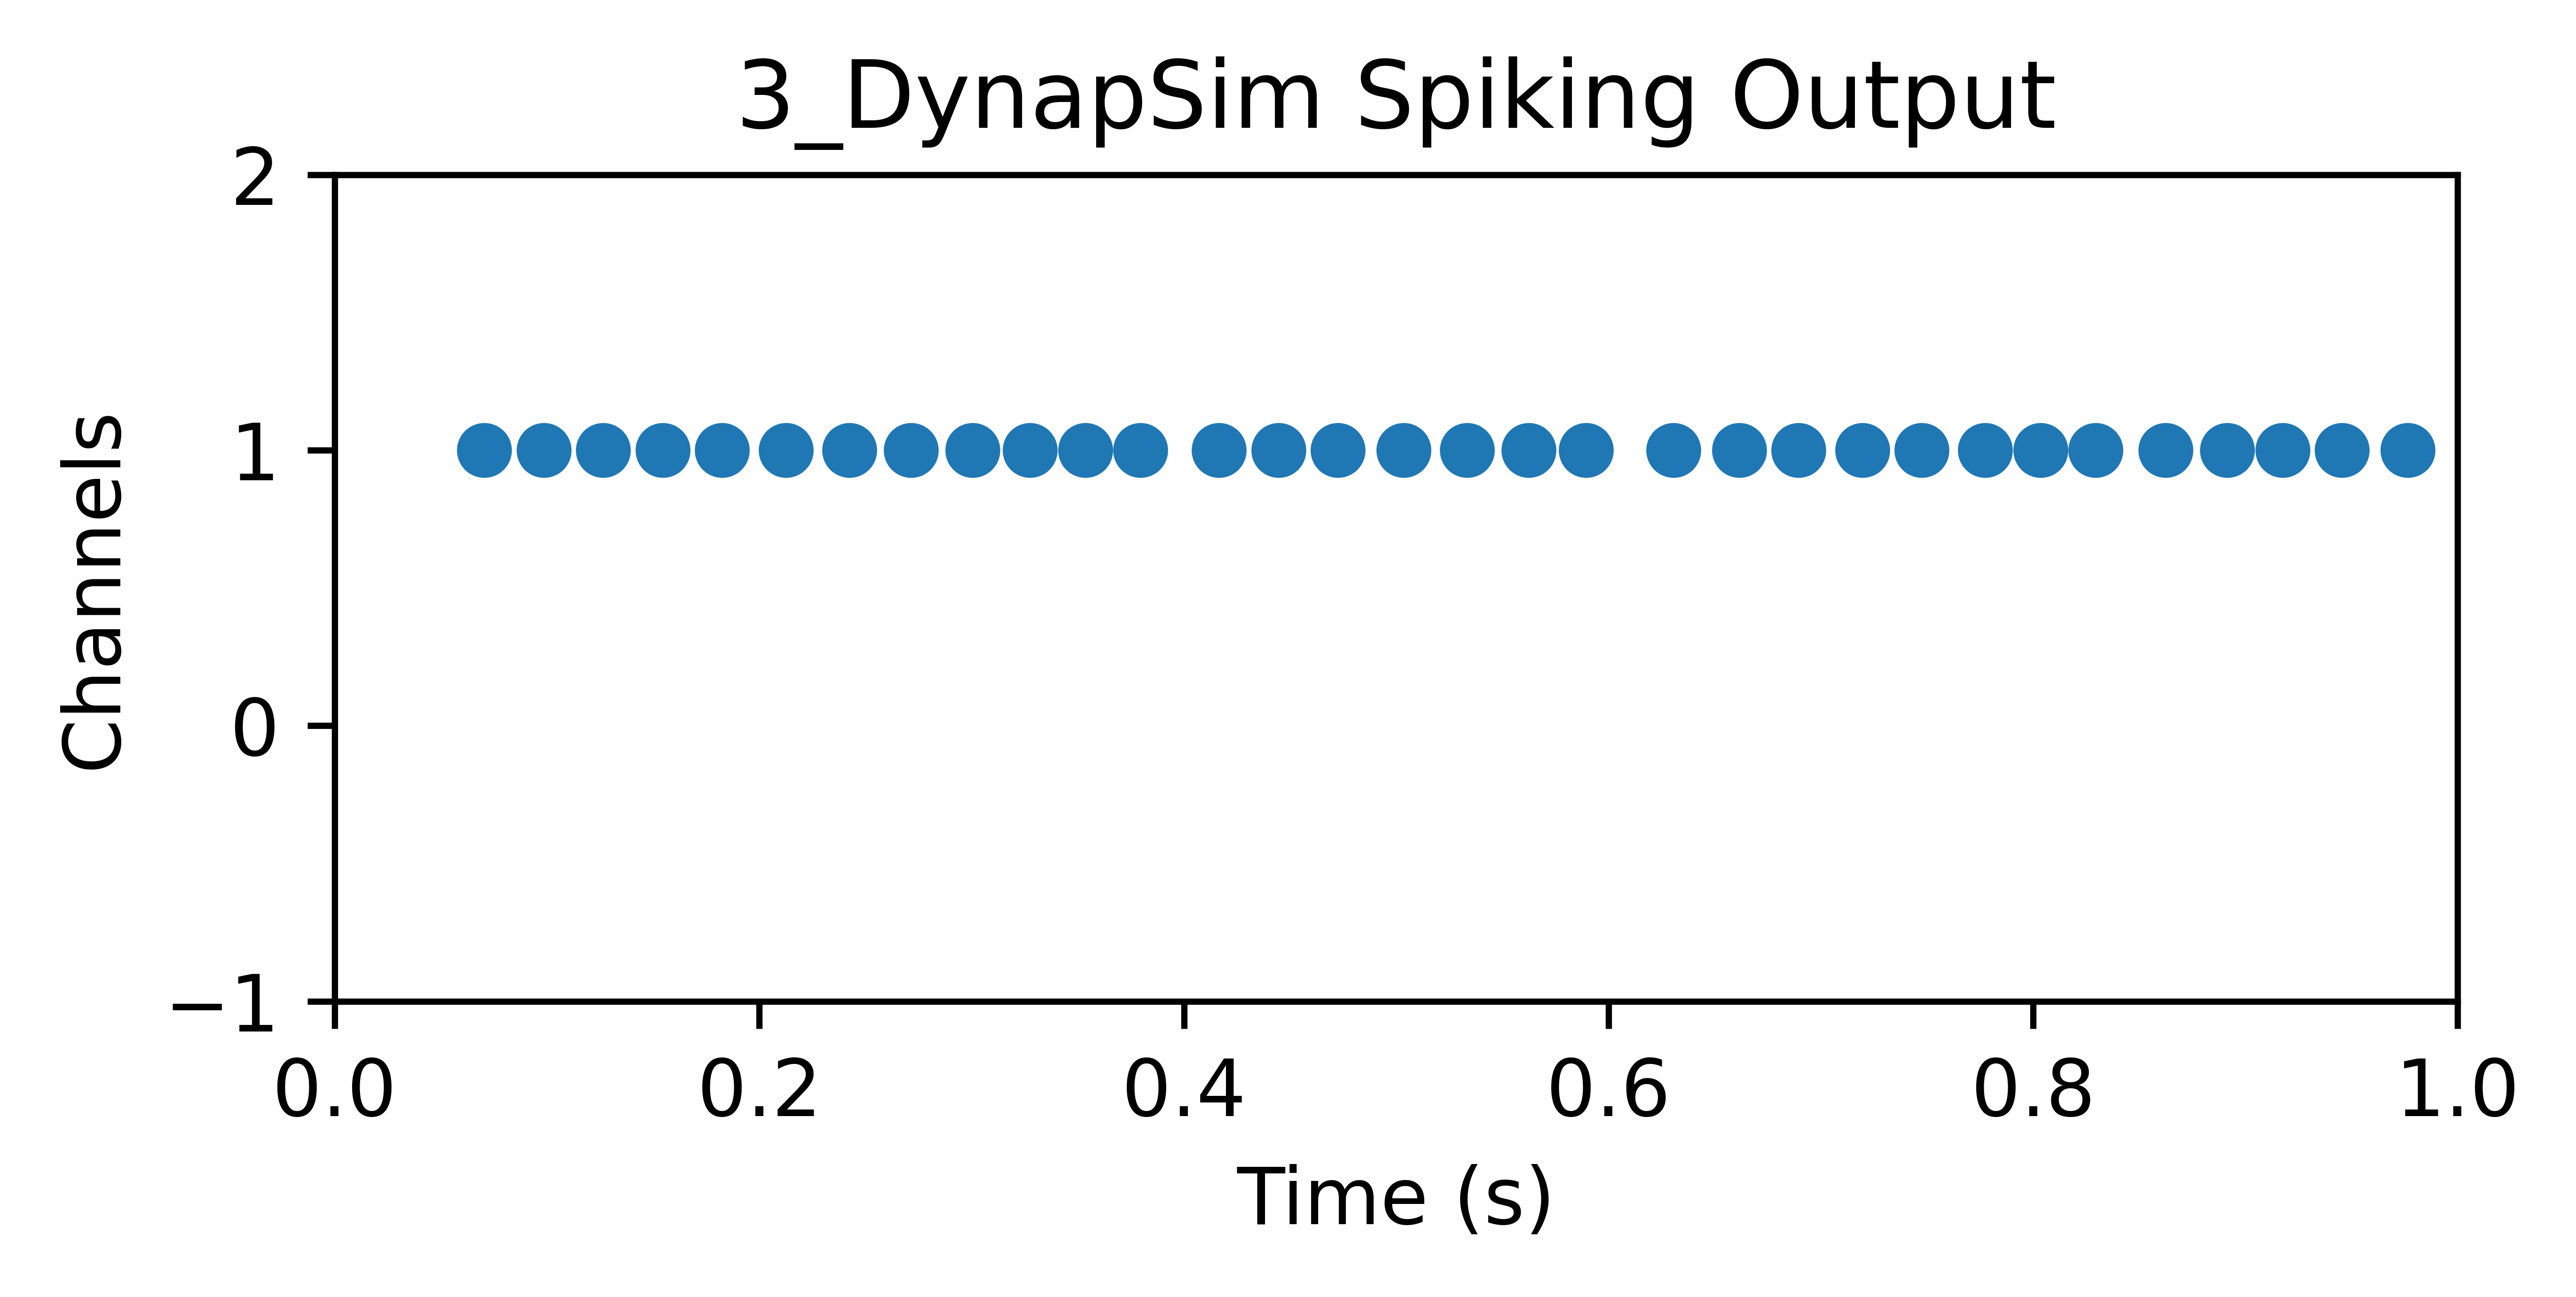

In [13]:
plot_raster(rec, "3_DynapSim", dt)

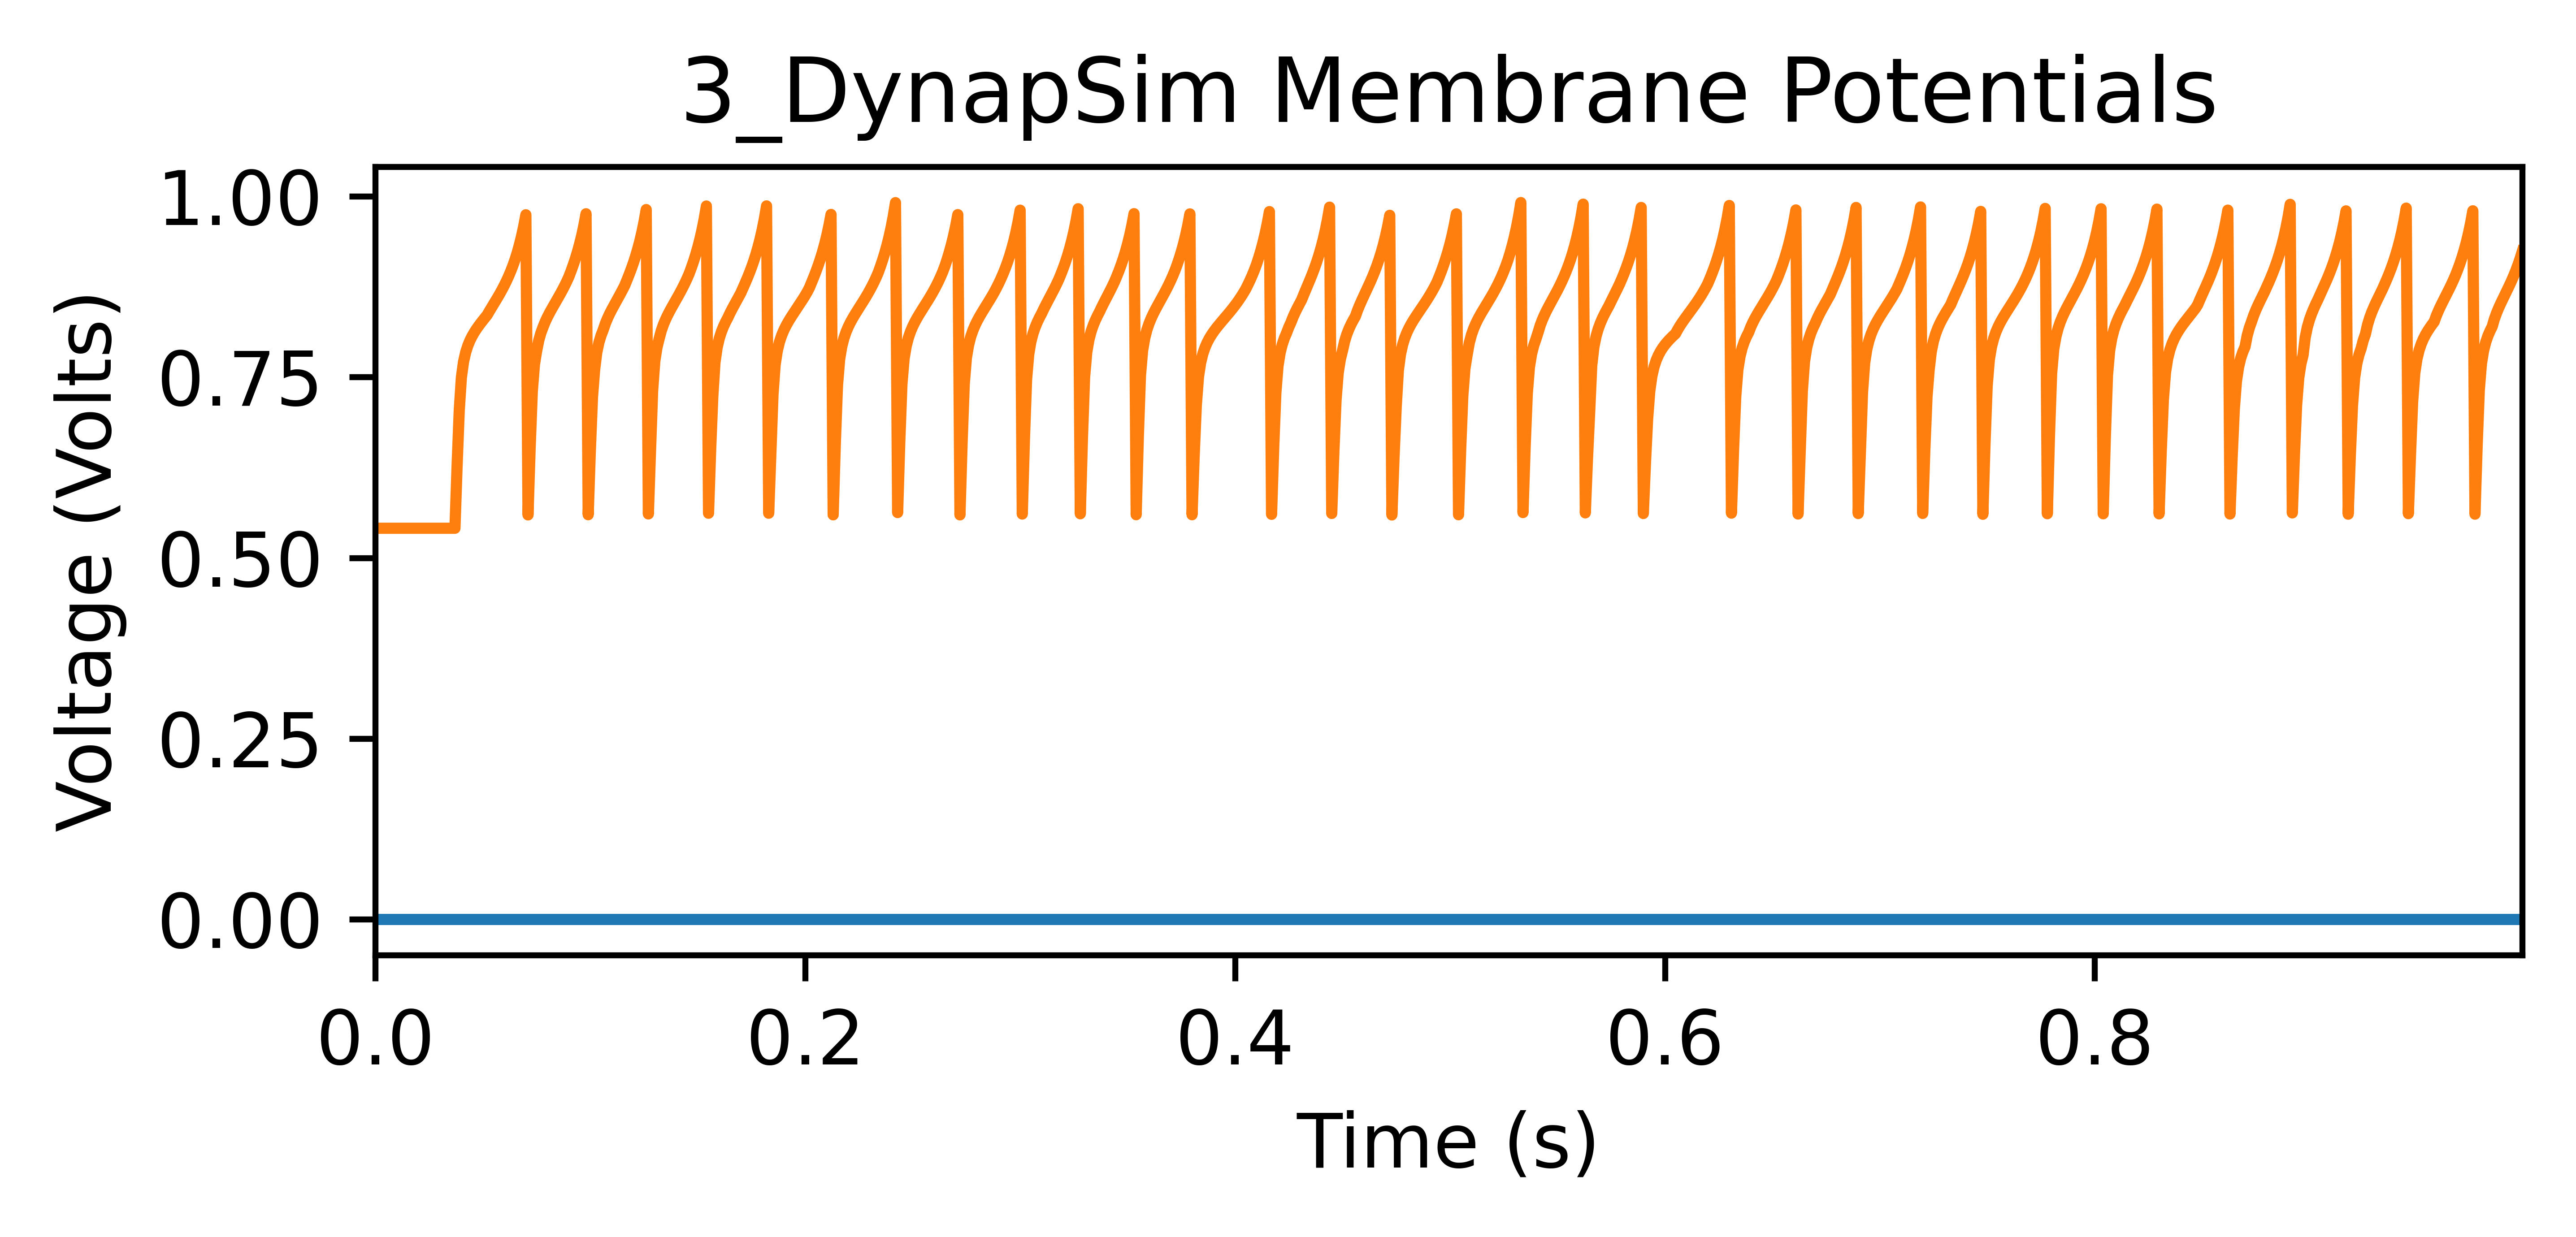

In [14]:
plot_vmem(rec, "3_DynapSim")

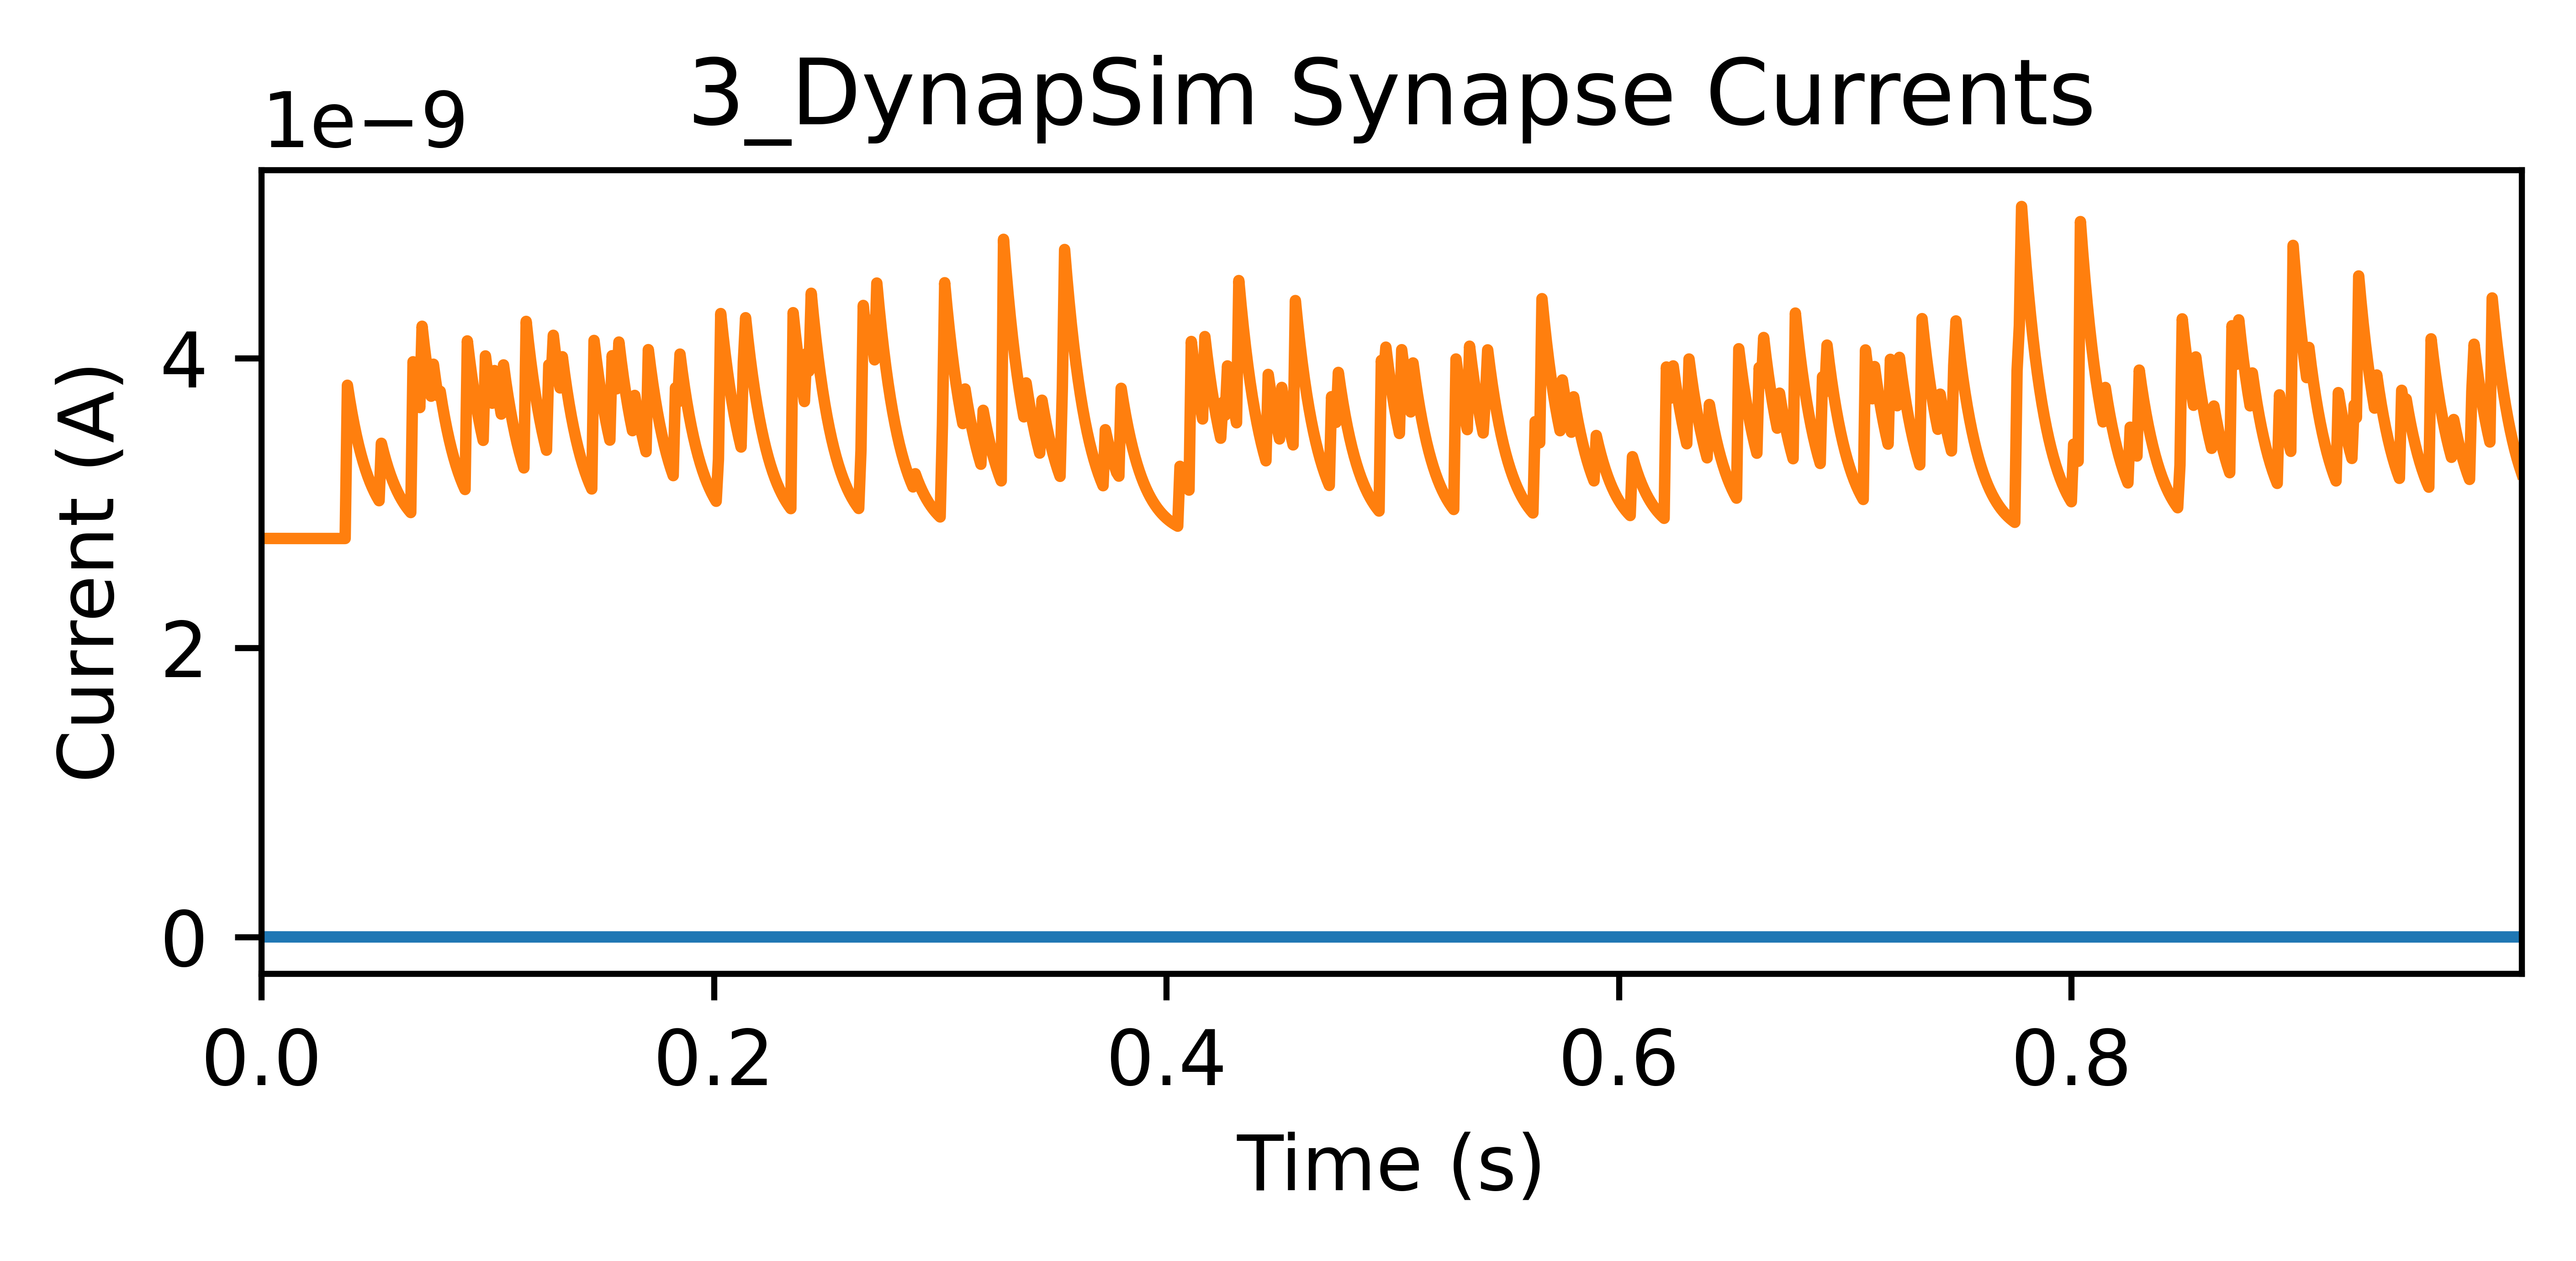

In [15]:
plot_isyn(rec, "3_DynapSim")

## Step 3 : Extract the graph and Map
In this step, we extract the computational graph of the entire network and try to allocate hardware resources.


In [16]:
spec = mapper(net.as_graph())
spec["Iscale"] *= 50

## Step 4 : Quantize Weights

In [17]:
spec.update(autoencoder_quantization(**spec))

## Step 5 : Obtain Hardware Config

In [18]:
config, input_channel_map = config_from_specification(**spec)


## Step 6 : Connect to Device

In [19]:
## Connect to device
se2_devices = find_dynapse_boards()

found_se2 = len(se2_devices) > 0

if not found_se2:
    raise IOError(
        "This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate."
    )
else:
    se2 = DynapseSamna(se2_devices[0], config, input_channel_map)


## Step 7 : Run the Simulation on Dynap-SE2

In [20]:
out, state, rec = se2(input_spikes[0], record=True)

<Figure size 5760x2880 with 0 Axes>

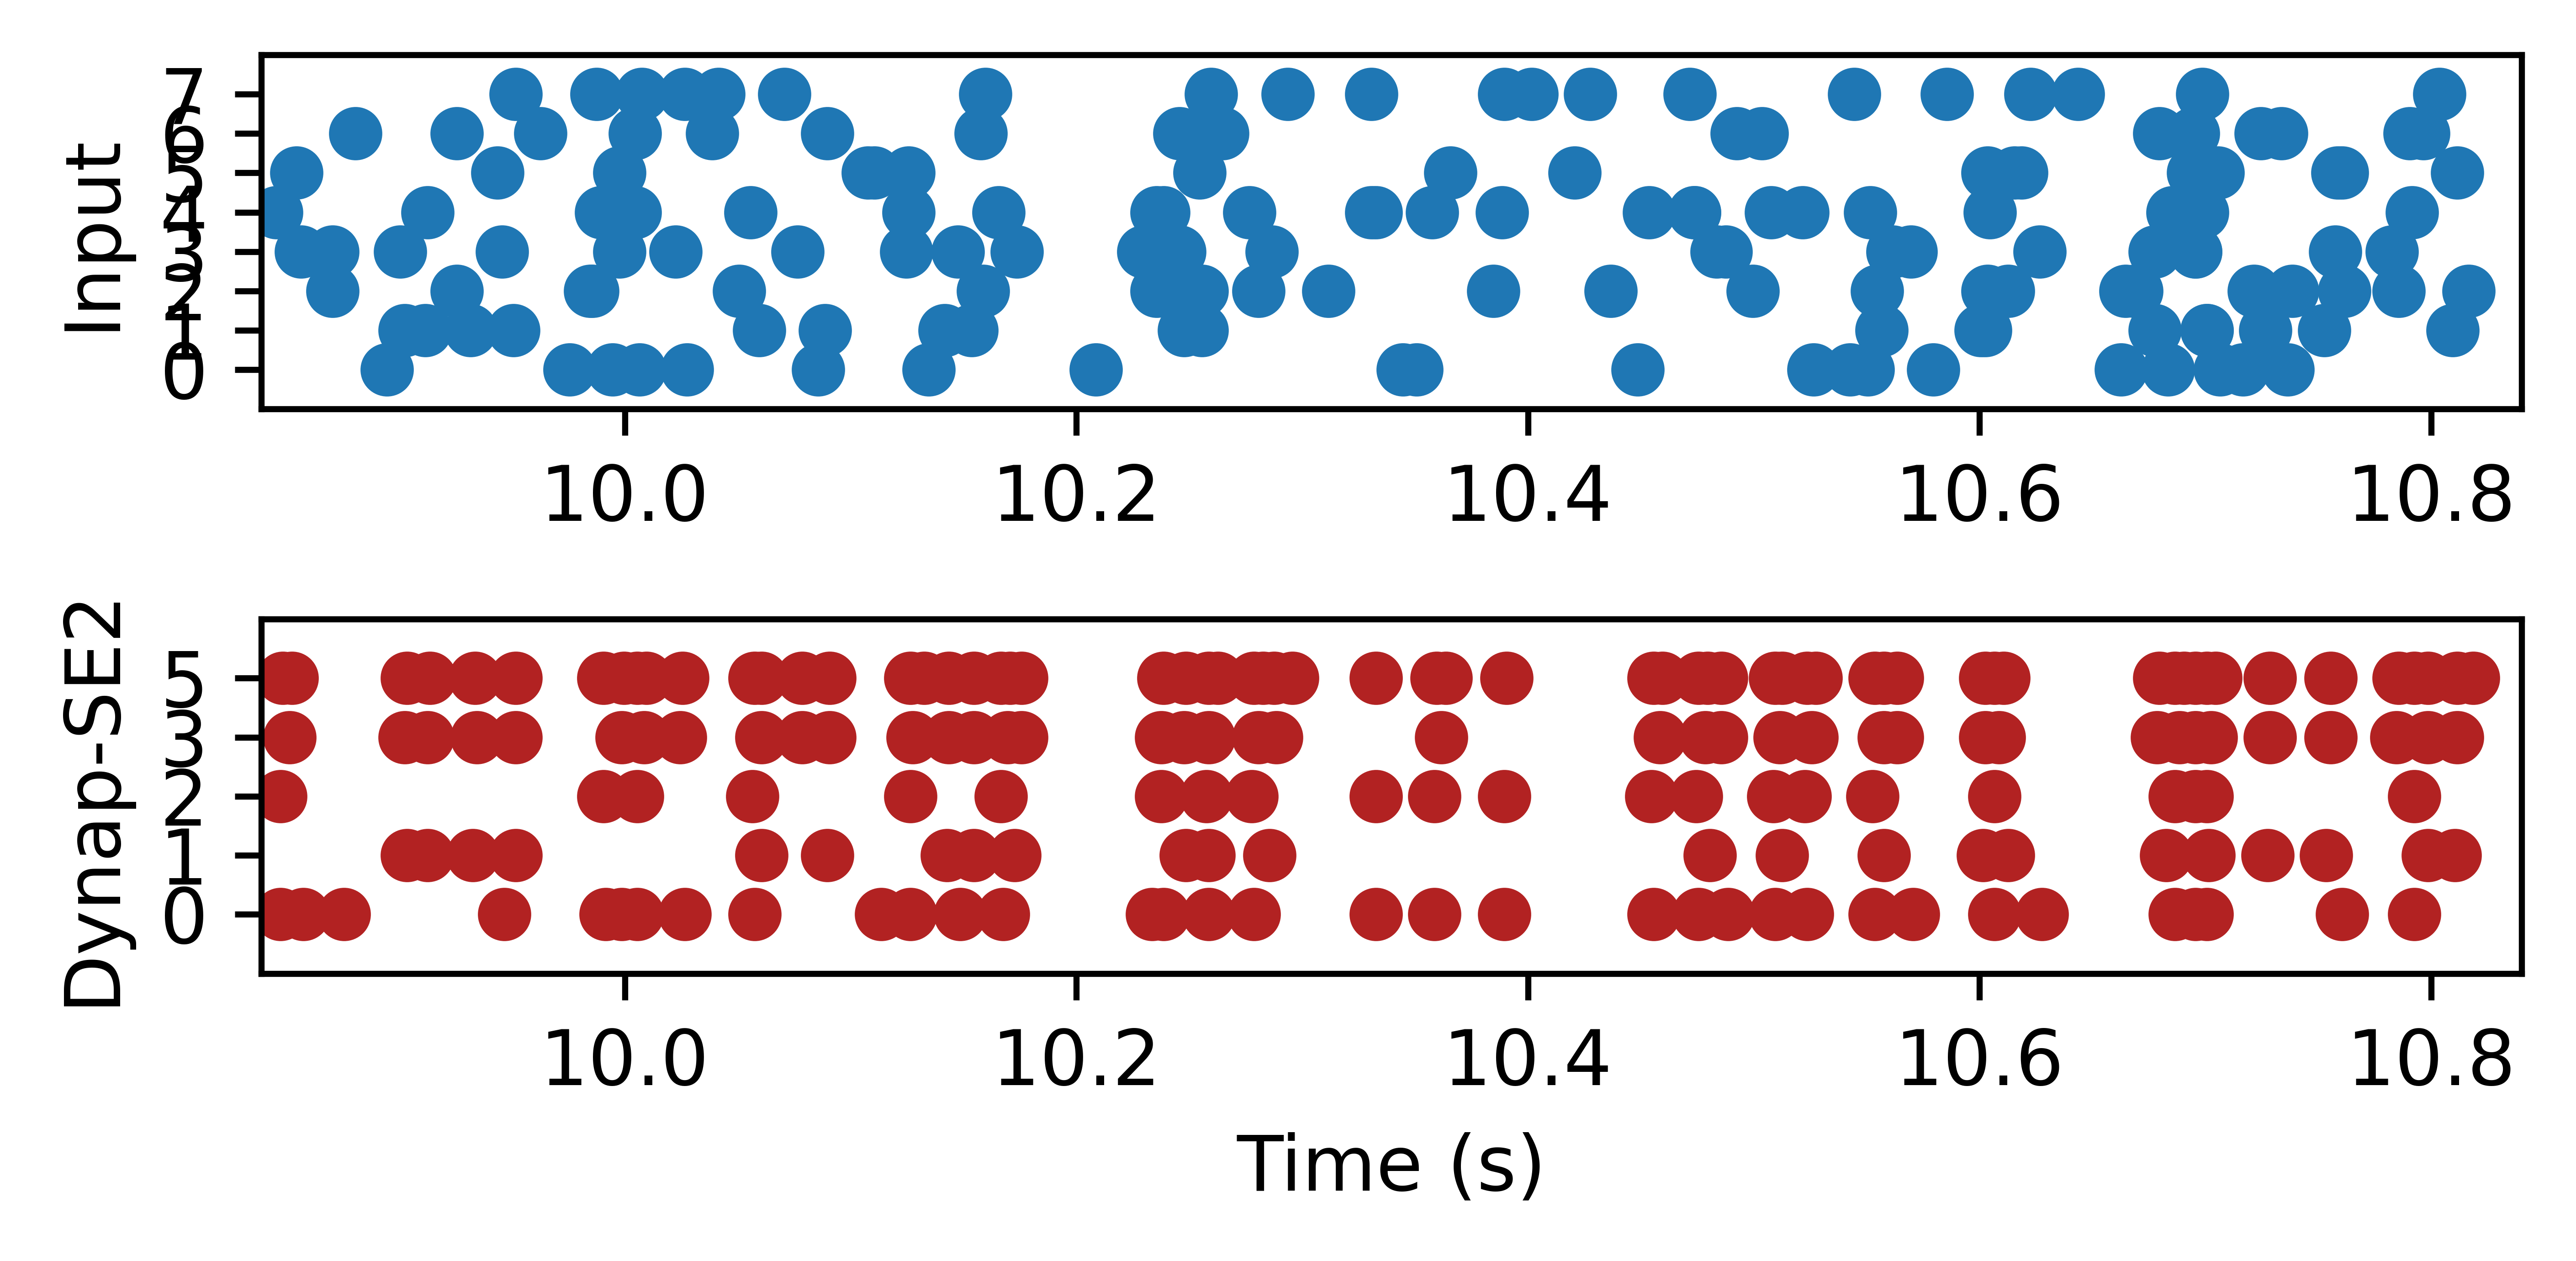

In [21]:
visualize_device_sim(input_spikes[0], out, rec, input_channel_map, se2.dt);

In [22]:
se2.disconnect()

## Step 8 : Run on Simulator

In [23]:
net_reconstructed = dynapsim_net_from_config(config, input_channel_map)
net_reconstructed[1].Iscale /= 50

In [24]:
net_reconstructed.reset_state()
out, state, rec = net_reconstructed(input_spikes[0])


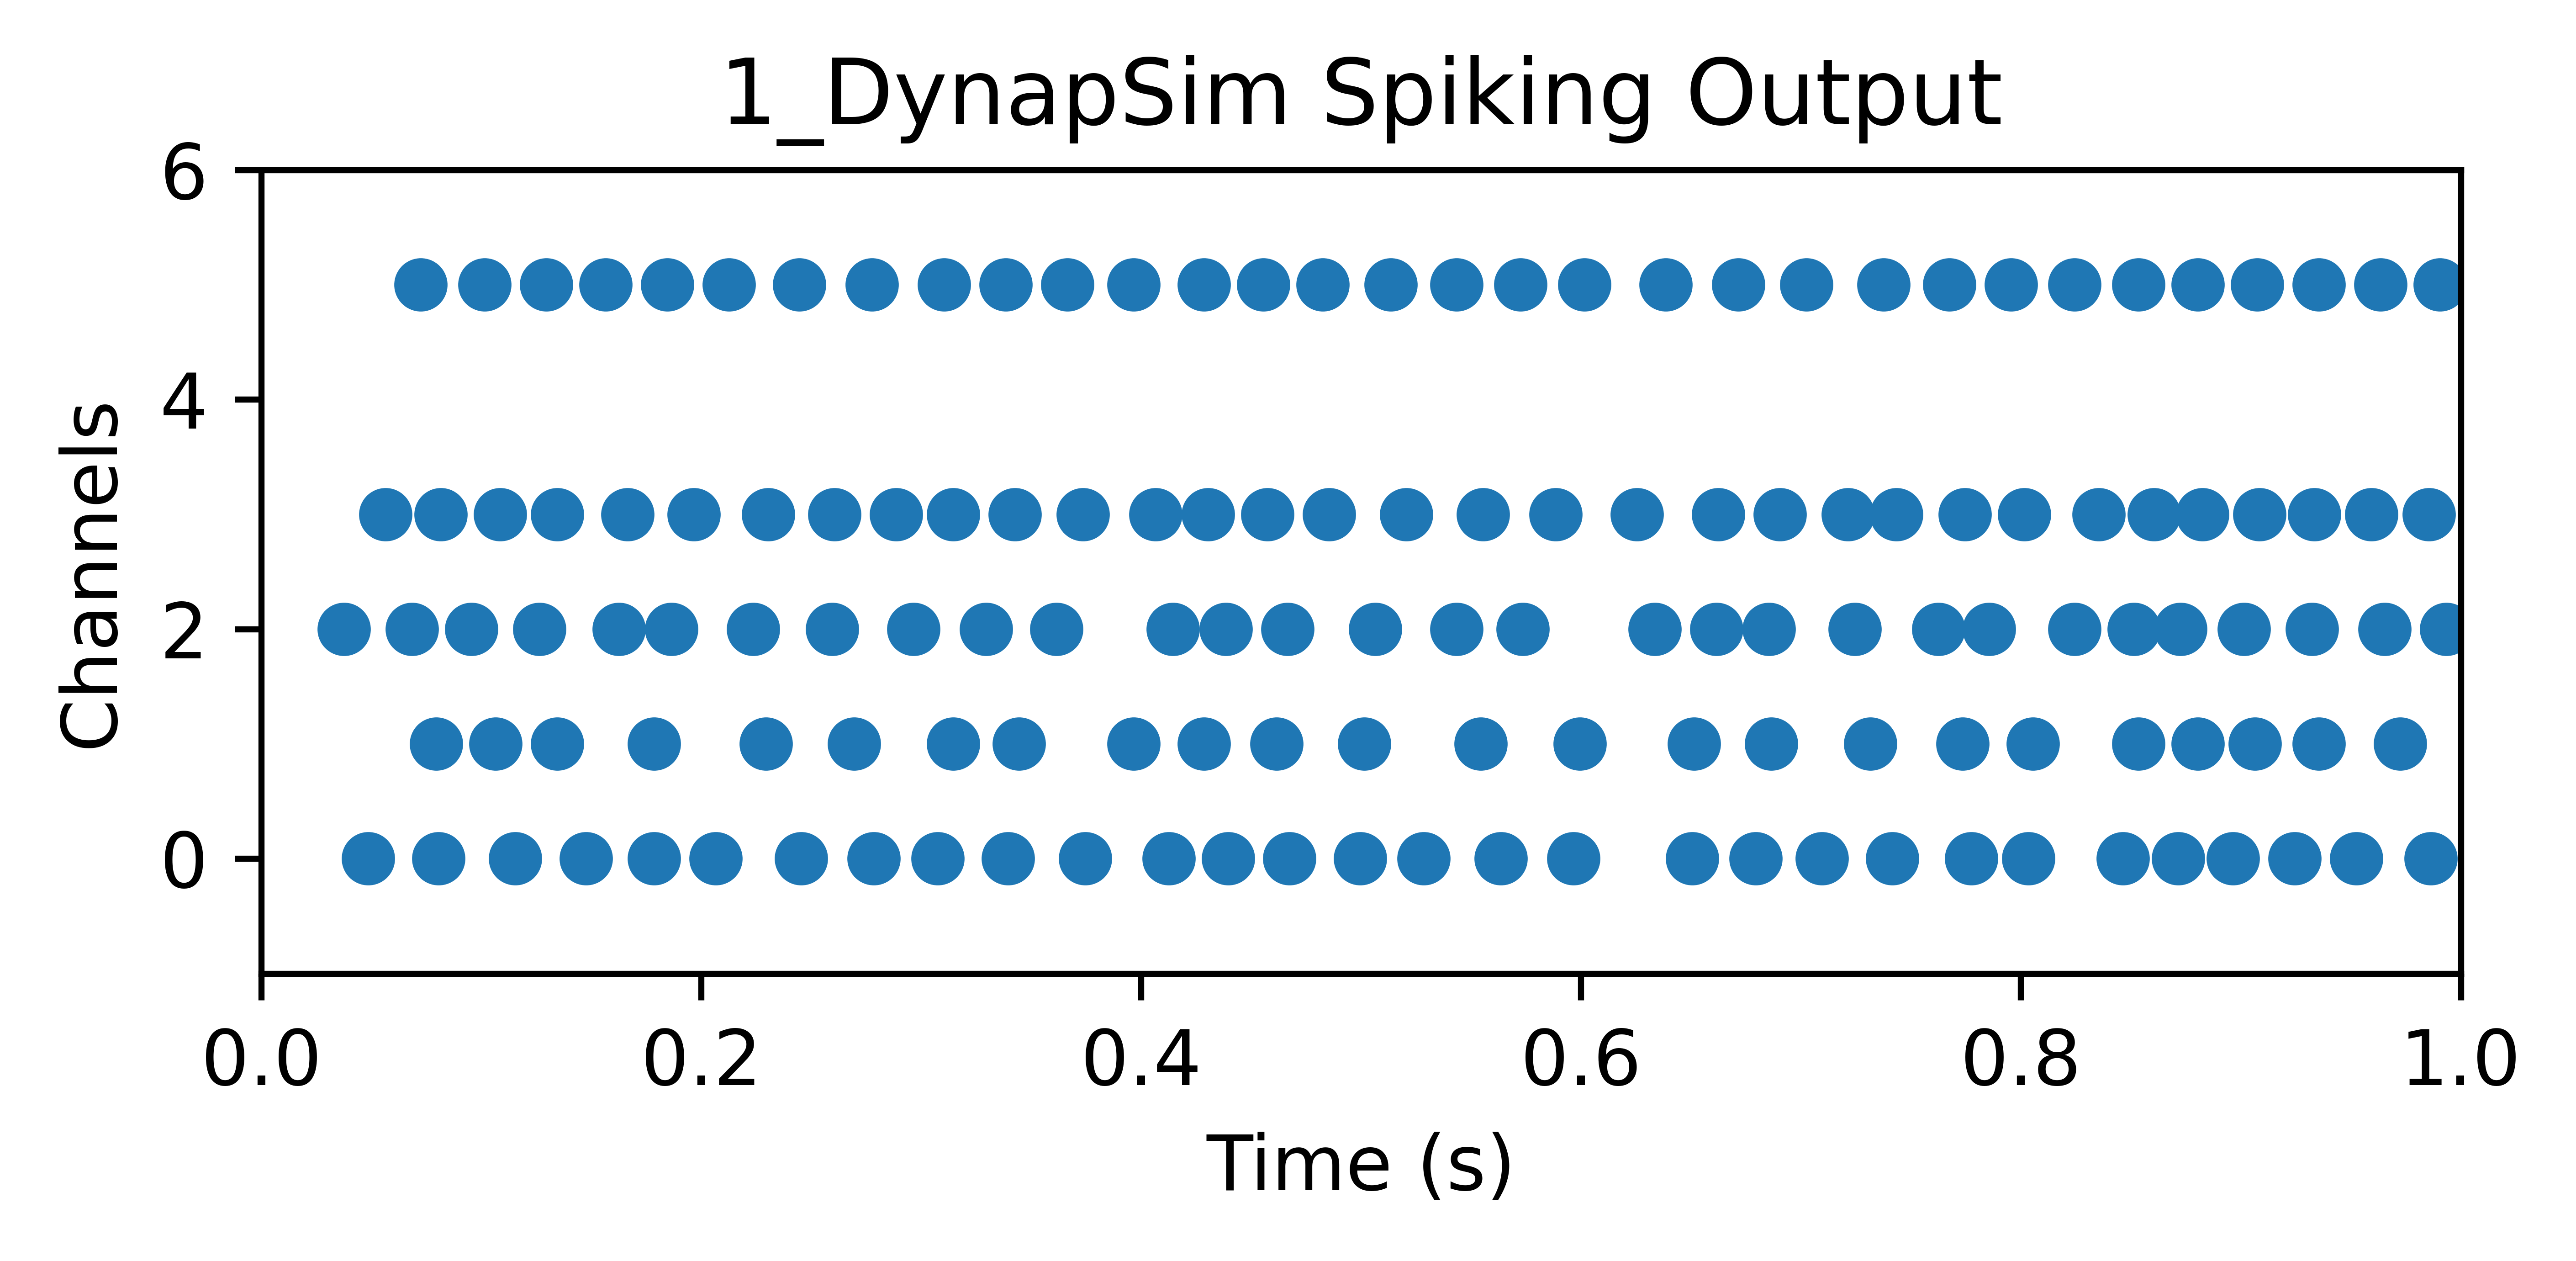

In [25]:
plot_raster(rec, "1_DynapSim", dt)

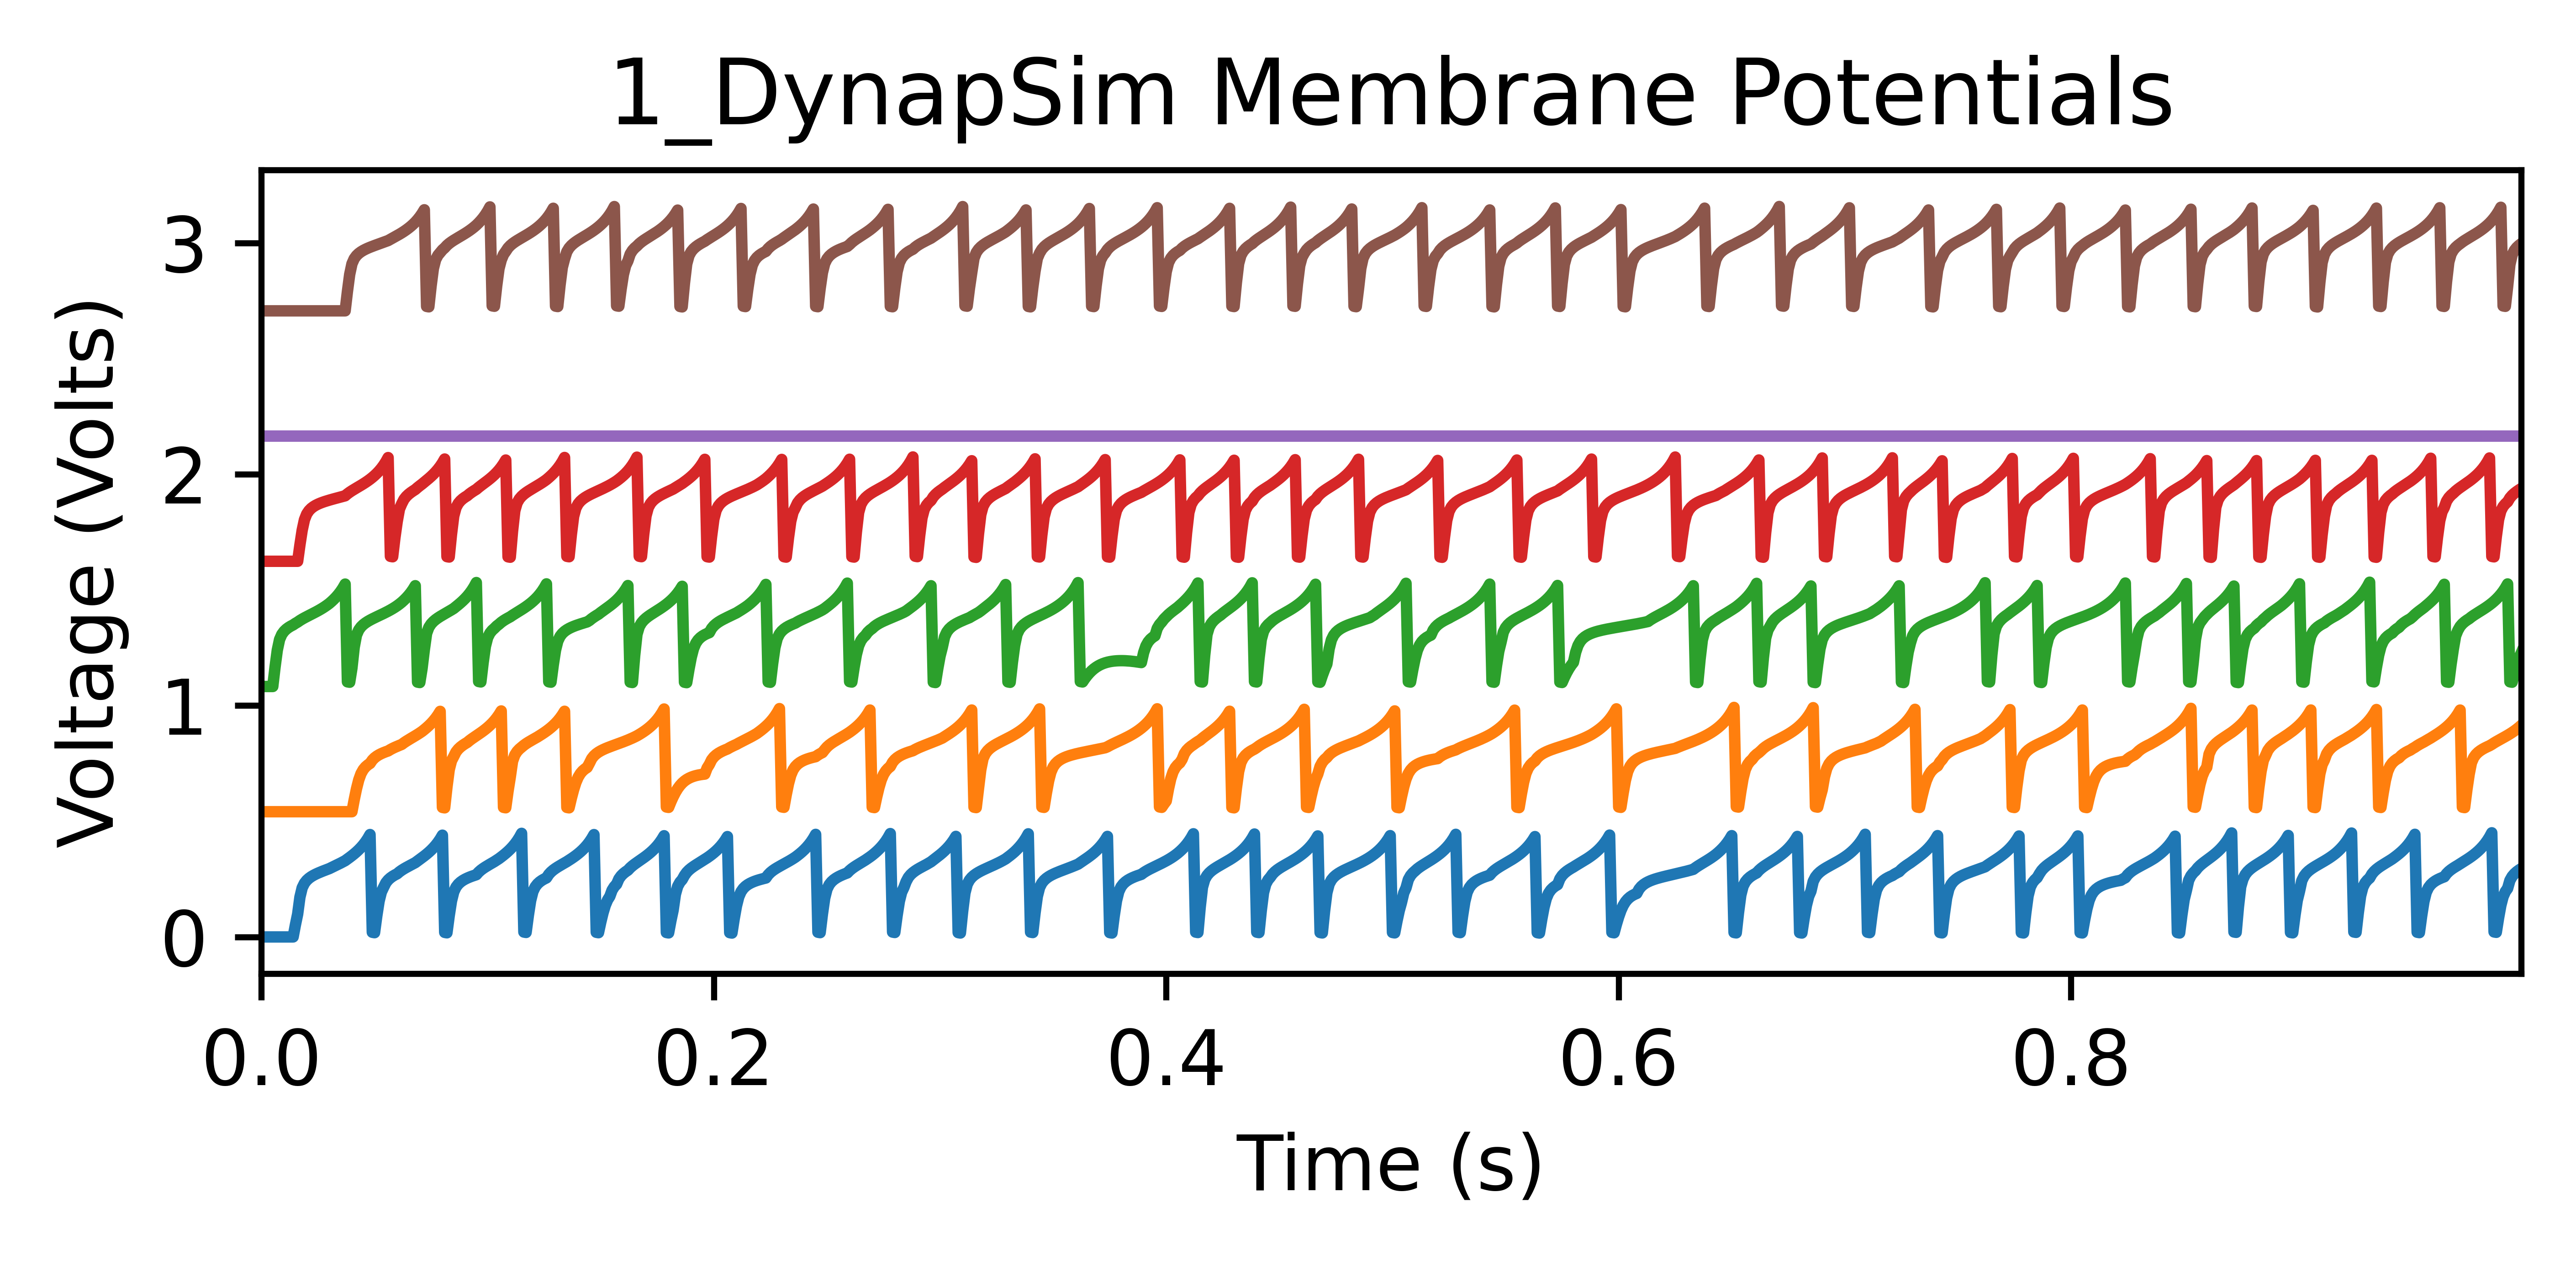

In [26]:
plot_vmem(rec, "1_DynapSim")